## Imports

In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import joblib
import numpy as np
    

## Loading/Inspecting Data

In [142]:

# load dataset into dataframe
# https://www.kaggle.com/datasets/barelydedicated/bank-customer-churn-modeling
file_path = "Churn_Modelling.csv"
df = pd.read_csv(file_path)

# print top rows
df.head()

RowNumber  CustomerId   Surname  ...  IsActiveMember EstimatedSalary Exited
0          1    15634602  Hargrave  ...               1       101348.88      1
1          2    15647311      Hill  ...               1       112542.58      0
2          3    15619304      Onio  ...               0       113931.57      1
3          4    15701354      Boni  ...               0        93826.63      0
4          5    15737888  Mitchell  ...               1        79084.10      0

[5 rows x 14 columns]

In [143]:
# shape of dataframe
df.shape

(10000, 14)

## Data visualisation

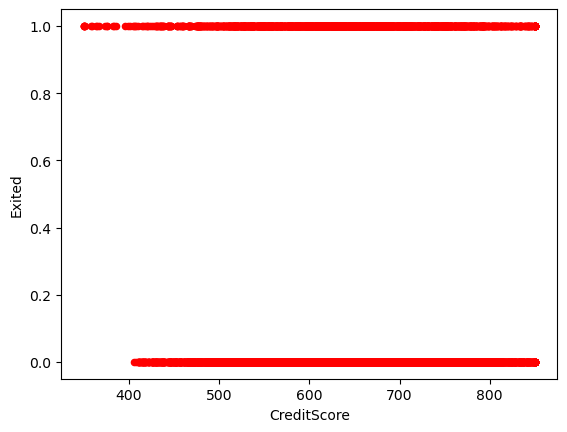

In [144]:
axis = df.plot.scatter(x='CreditScore', y='Exited', c='red')

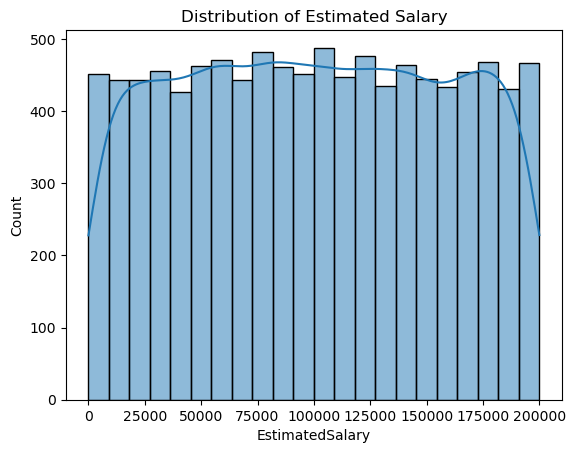

In [145]:
sns.histplot(df['EstimatedSalary'], kde=True)
plt.title('Distribution of Estimated Salary')
plt.show()

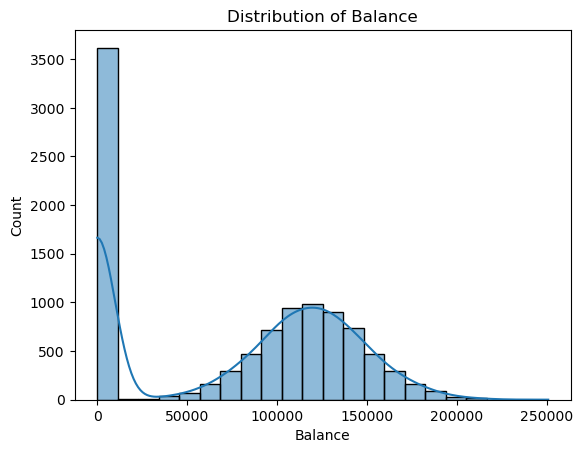

In [146]:
sns.histplot(df['Balance'], kde=True)
plt.title('Distribution of Balance')
plt.show()

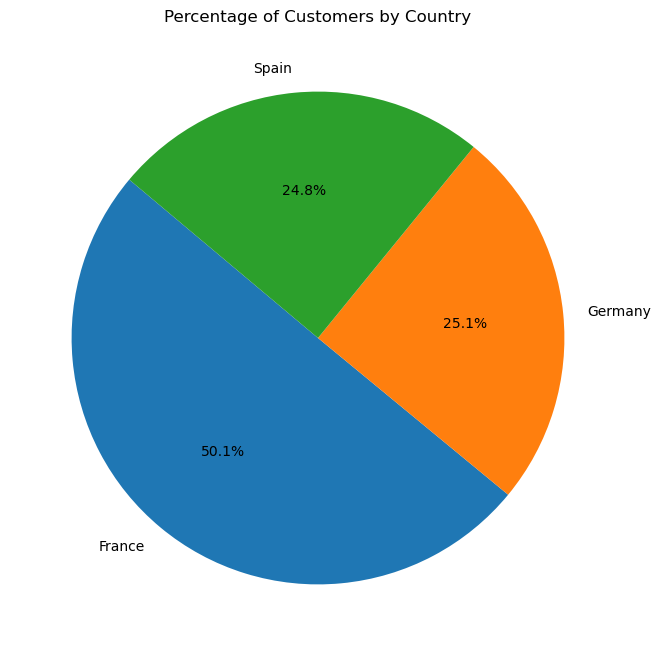

In [147]:
geo_counts = df['Geography'].value_counts()
geo_percentages = (geo_counts / geo_counts.sum()) * 100

plt.figure(figsize=(8, 8))
plt.pie(
    geo_percentages,
    labels=geo_counts.index,
    autopct='%1.1f%%',
    startangle=140,
)
plt.title("Percentage of Customers by Country")
plt.show()


## Preprocessing

In [148]:
# drop duplicated rows
df.drop_duplicates(inplace=True)
df.shape

(10000, 14)

In [149]:

# drop irrelevant columns
df_cleaned = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# define features and target variable
X = df_cleaned.drop(columns=['Exited'])
y = df_cleaned['Exited']
print(X.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


In [150]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

le_geography = LabelEncoder()
le_gender = LabelEncoder()

X['Geography'] = le_geography.fit_transform(X['Geography'])
X['Gender'] = le_gender.fit_transform(X['Gender'])

le_y = LabelEncoder()
y = le_y.fit_transform(y)

X= X[numerical_features + ['Geography', 'Gender']].values

In [151]:
rs = RandomOverSampler(random_state=0)
X, y = rs.fit_resample(X, y)

## Run 1: no alterations

In [152]:
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size = 0.4, stratify=y)

## Oversample

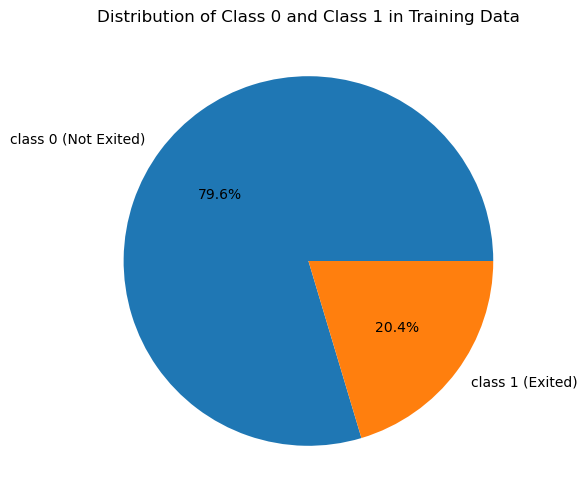

In [153]:
class_0 = df[df['Exited'] == 0]
class_1 = df[df['Exited'] == 1]

class_counts = [len(class_0), len(class_1)]
classes = ['class 0 (Not Exited)', 'class 1 (Exited)']

plt.figure(figsize=(6, 6))
plt.pie(
    class_counts,
    labels=classes,
    autopct='%1.1f%%',
)
plt.title('Distribution of Class 0 and Class 1 in Training Data')
plt.show()

plt.show()

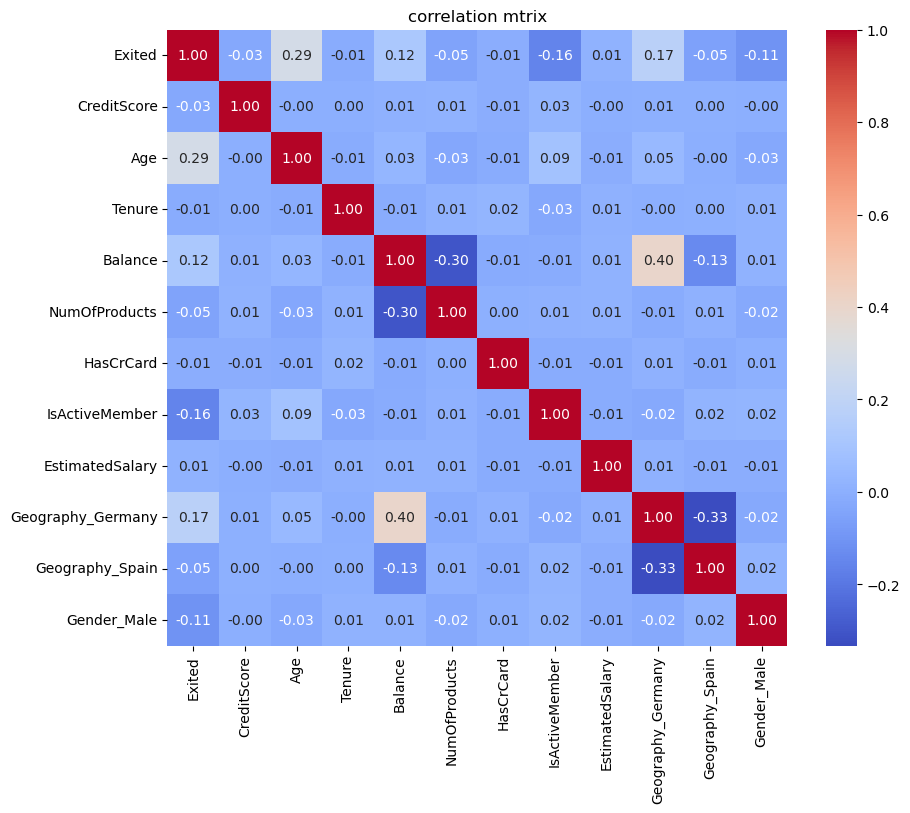

In [154]:
df_insights = df[['Exited','CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]

df_insights.describe()
df_encoded = pd.get_dummies(df_insights, drop_first=True)

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("correlation mtrix")
plt.show()


## Run 2: Oversample + pre tuning

In [155]:
dt = tree.DecisionTreeClassifier(random_state=0)
dt.fit(x_train, y_train)

y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)
    

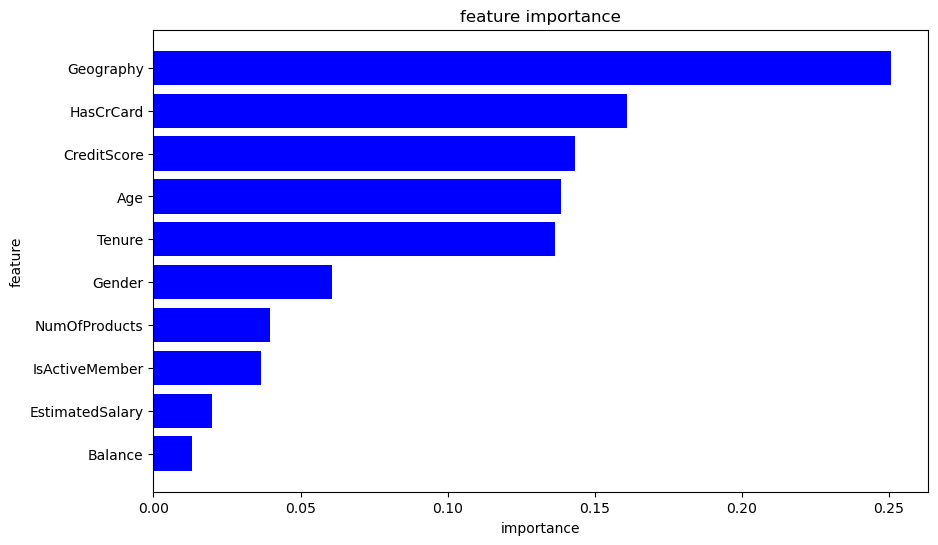

In [156]:
importance = dt.feature_importances_

feature_names = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Score': importance
}).sort_values(by='Score', ascending=False)



plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'], df_importance['Score'], color='blue')
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('feature importance')
plt.gca().invert_yaxis()
plt.savefig('ROSfeat.png', dpi=300)
plt.show()

Text(0.5, 1.0, 'Decision Tree Visualization')

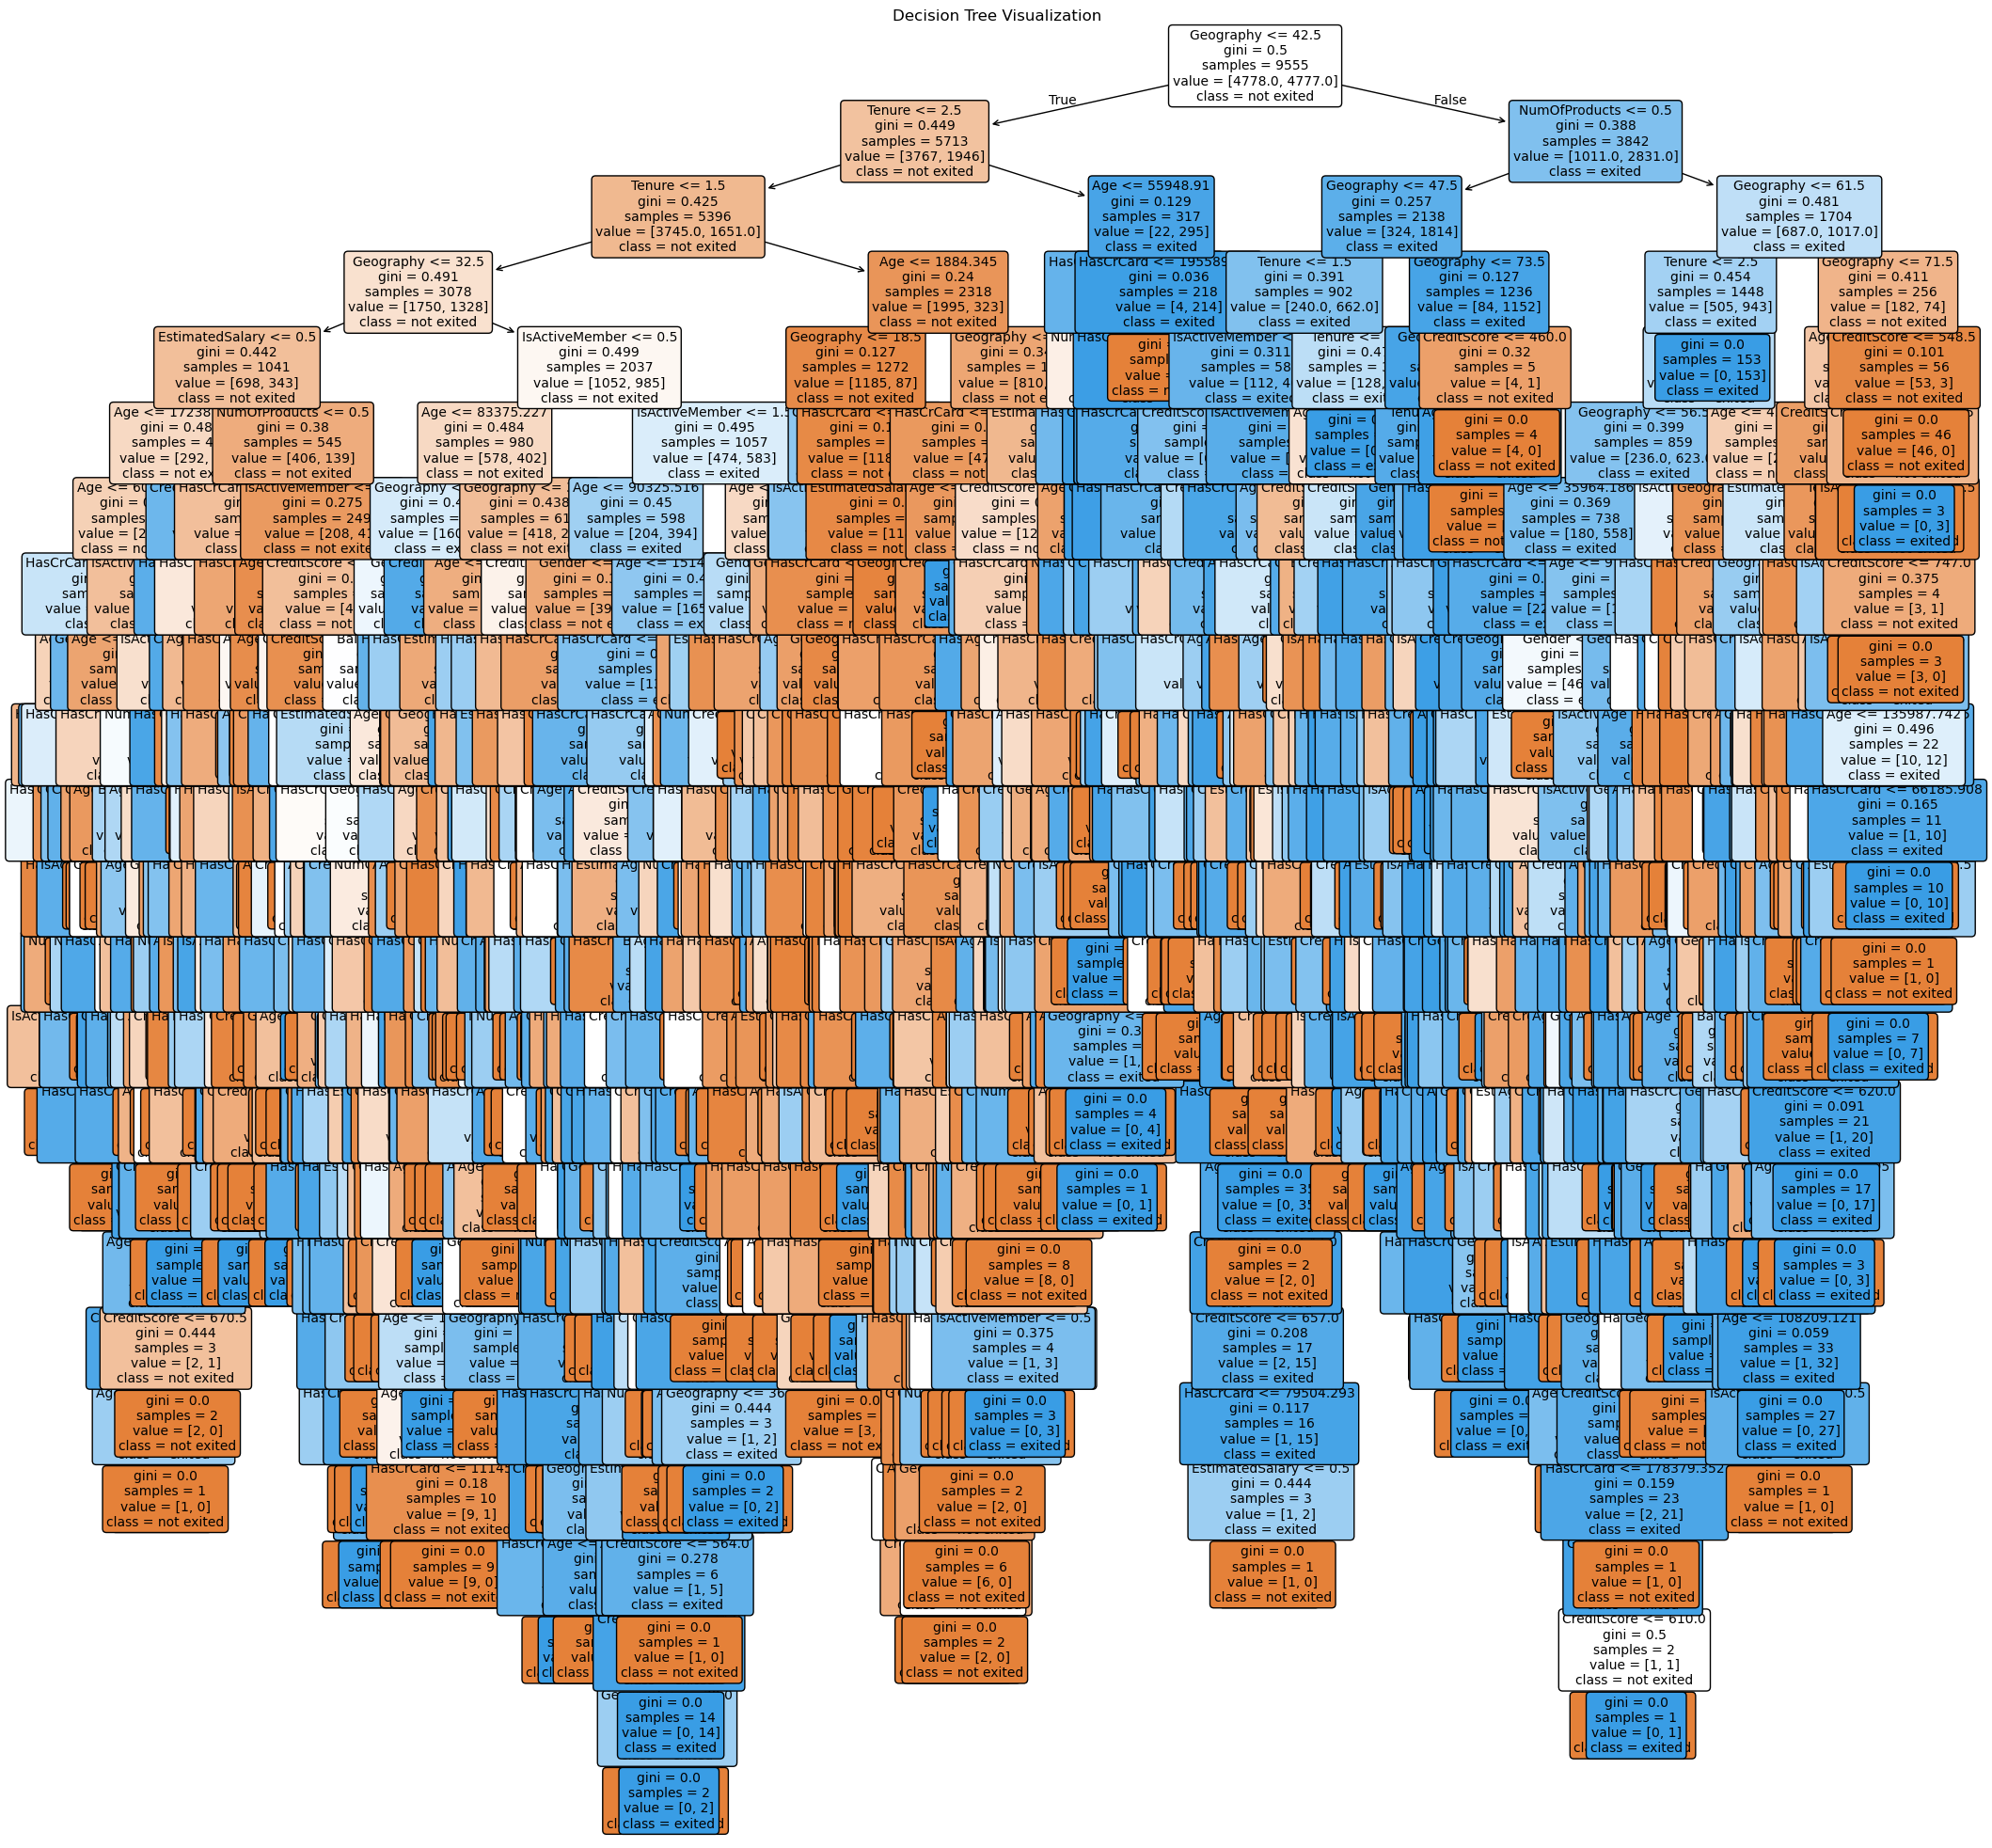

In [157]:
plt.figure(figsize=(25, 25))
plot_tree(
    dt,
    feature_names=feature_names,
    class_names=['not exited', 'exited'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")

Train score: 1.0
Test score: 0.8935802856694397


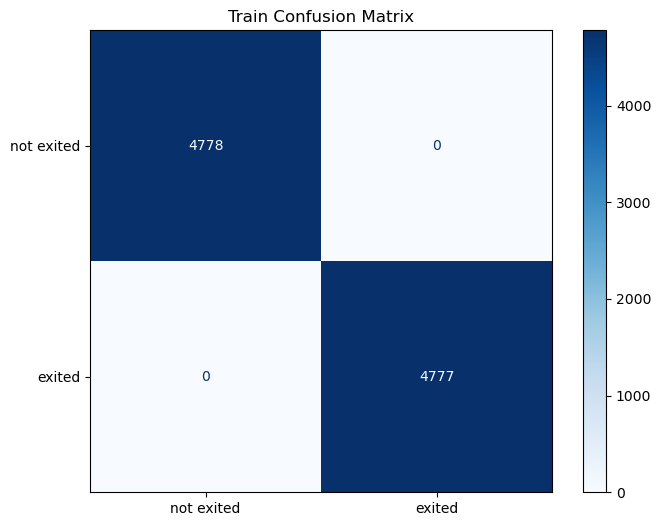

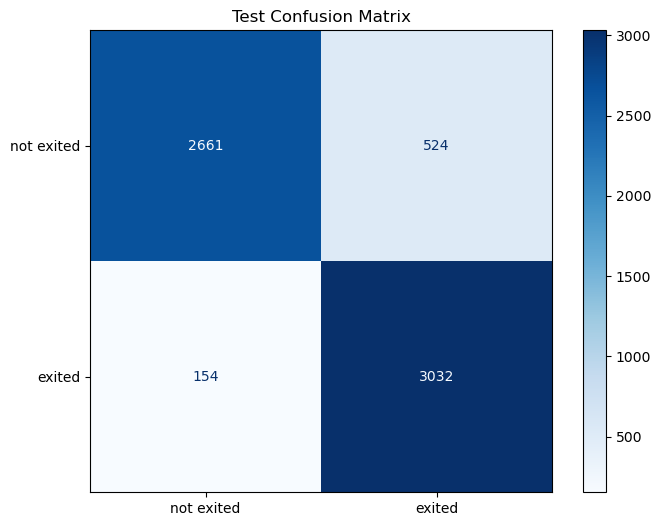

In [158]:
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

train_score = dt.score(x_train, y_train)
test_score = dt.score(x_test, y_test)

print("Train score:", train_score)
print("Test score:", test_score)

custom_labels = ['not exited', 'exited']

plt.figure(figsize=(8, 6))
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=custom_labels)
disp_train.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.gca().set_xlabel("")
plt.gca().set_ylabel("")
plt.title("Train Confusion Matrix")
plt.show()

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=custom_labels)
disp_test.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.gca().set_xlabel("")
plt.gca().set_ylabel("")
plt.title("Test Confusion Matrix")
plt.show()

In [159]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
results = classification_report(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nResults:\n", results)
print("\nAccuracy:", accuracy)

Confusion Matrix:
 [[2661  524]
 [ 154 3032]]

Results:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      3185
           1       0.85      0.95      0.90      3186

    accuracy                           0.89      6371
   macro avg       0.90      0.89      0.89      6371
weighted avg       0.90      0.89      0.89      6371


Accuracy: 0.8935802856694397


## Run 3: Gridsearch

{'class_weight': 'balanced', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}


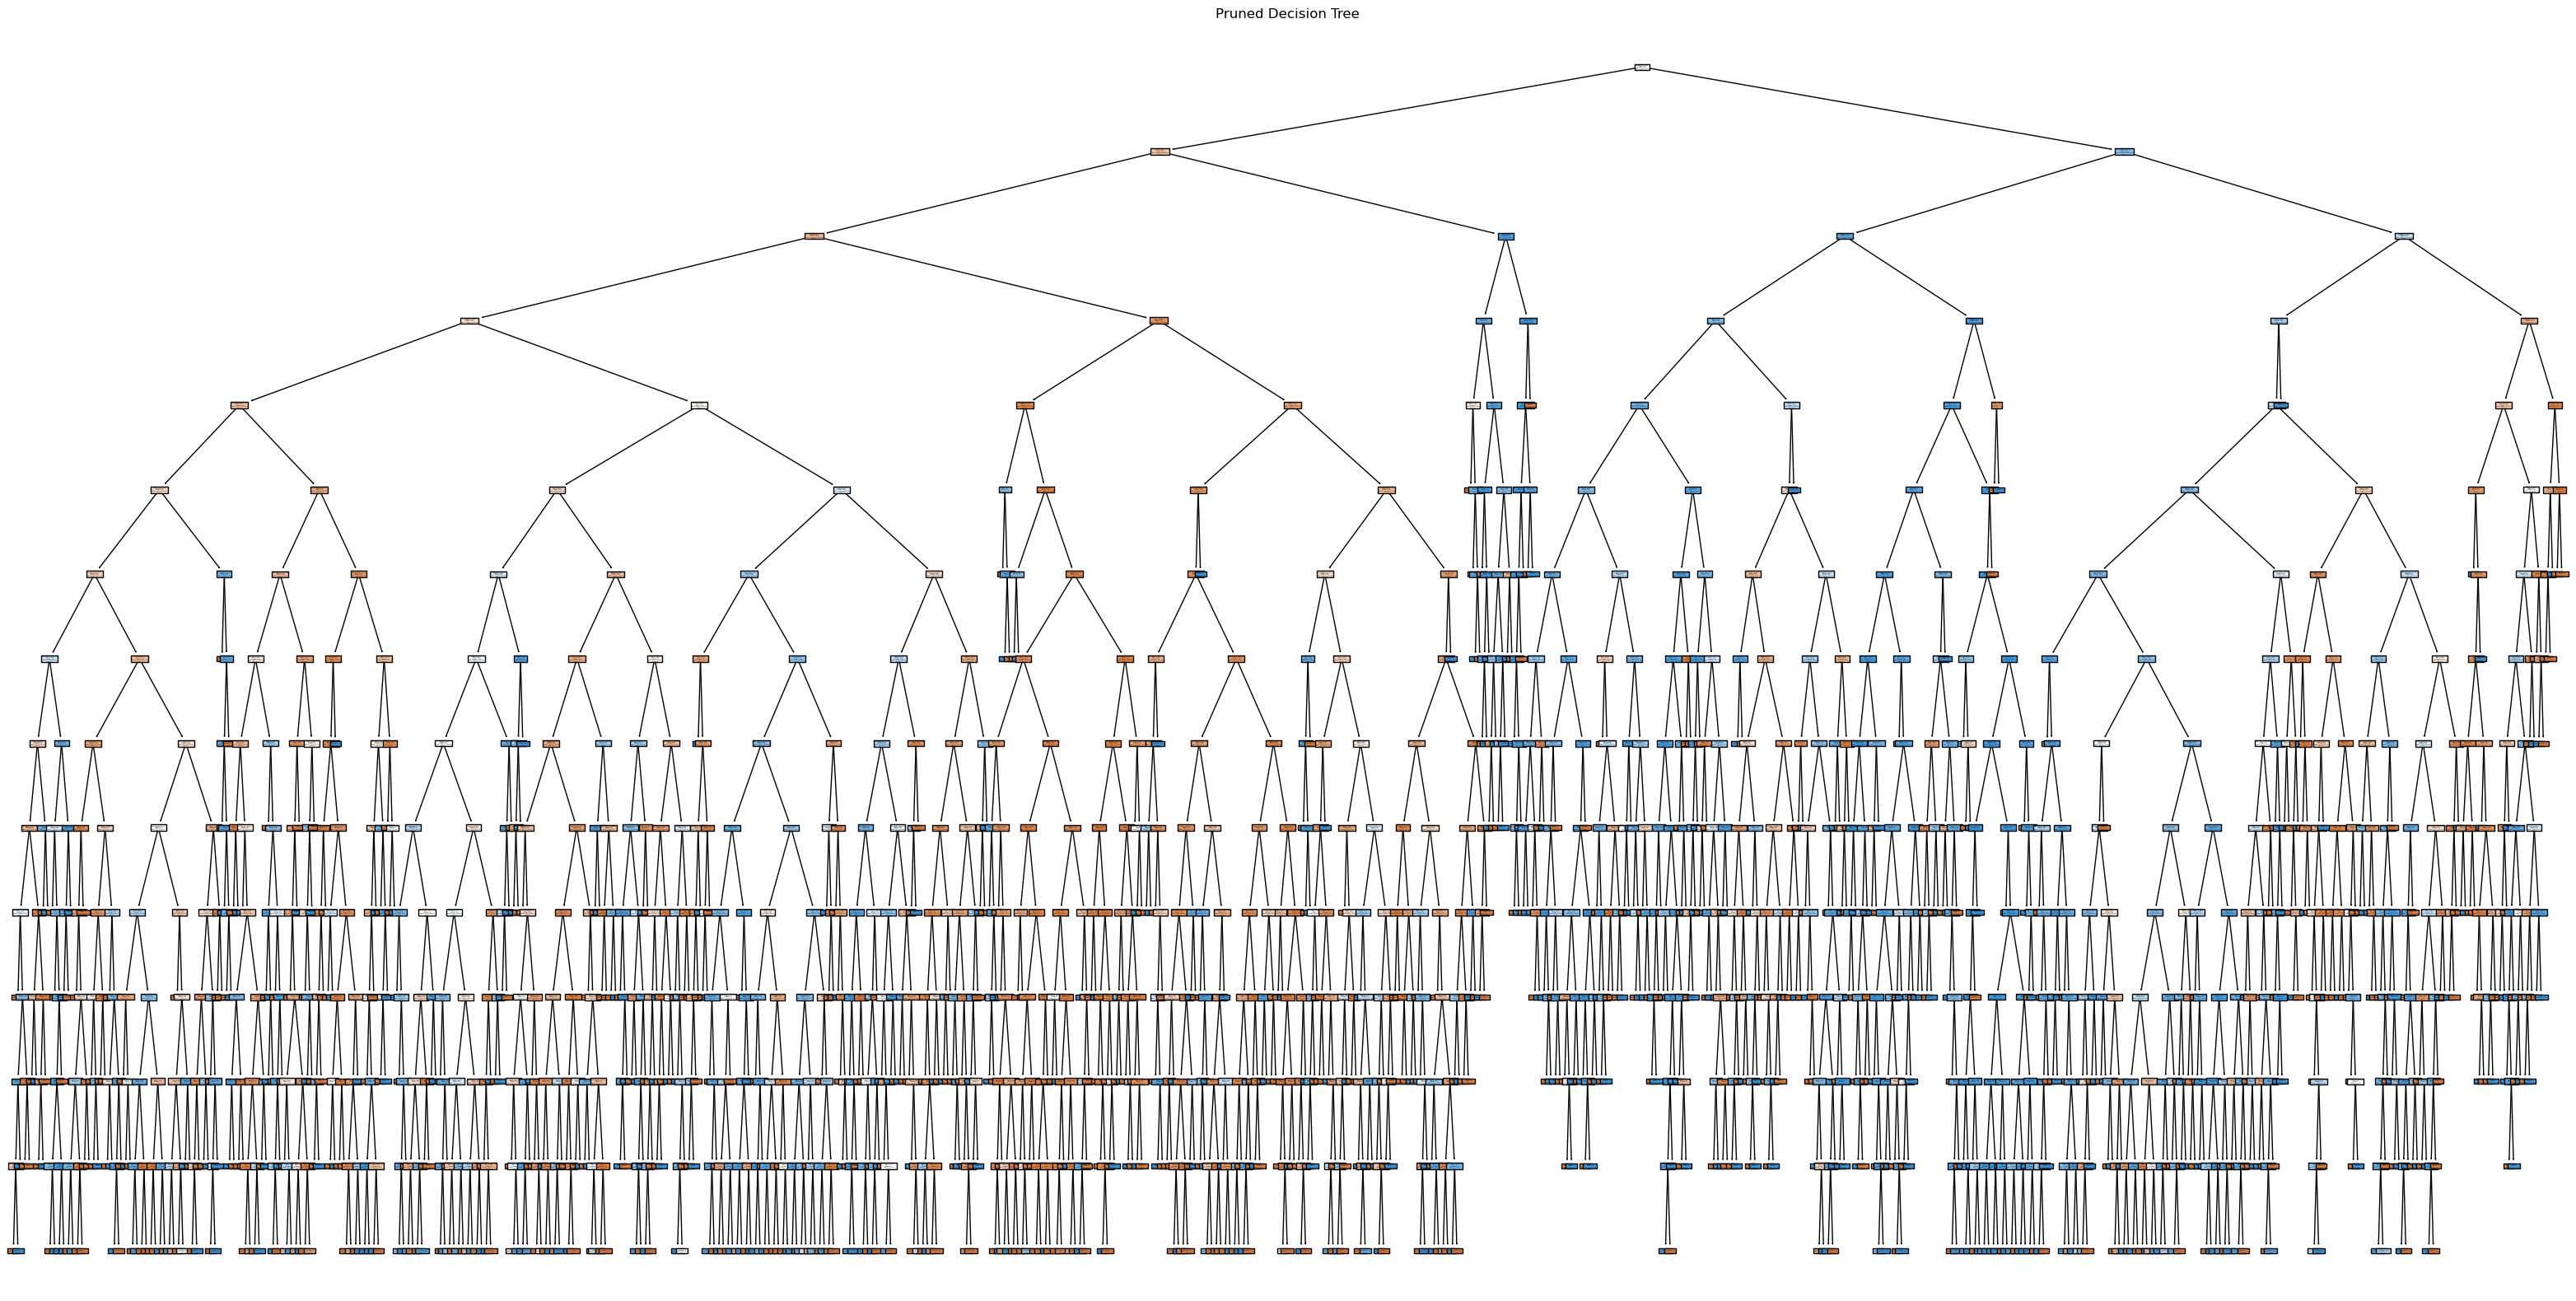

In [160]:
params = {
    'max_depth': [2,4,6,8,10,12,14],
    'min_samples_split': [2, 3, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}


clf = tree.DecisionTreeClassifier(random_state=0)
gcv = GridSearchCV(estimator=clf, param_grid=params, cv=5)
gcv.fit(x_train,y_train)
print(gcv.best_params_)
best_tree = gcv.best_estimator_
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 20))
plot_tree(best_tree, feature_names=feature_names, class_names=["0", "1"], filled=True)
plt.title("Pruned Decision Tree")
plt.show()

Train score: 0.9683935112506541
Test score: 0.8777272013812588


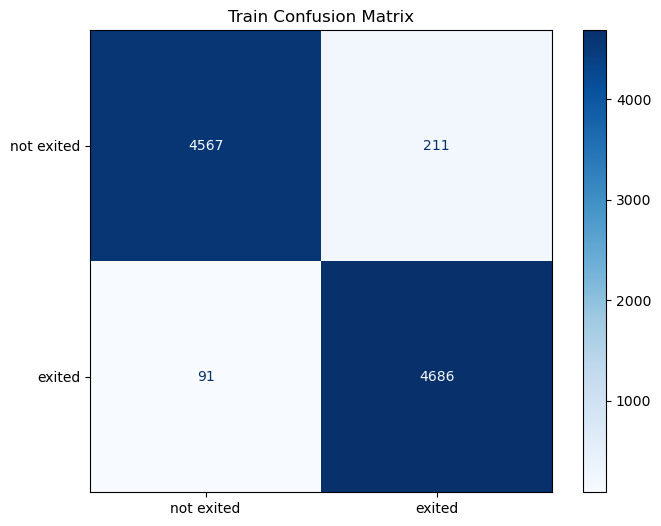

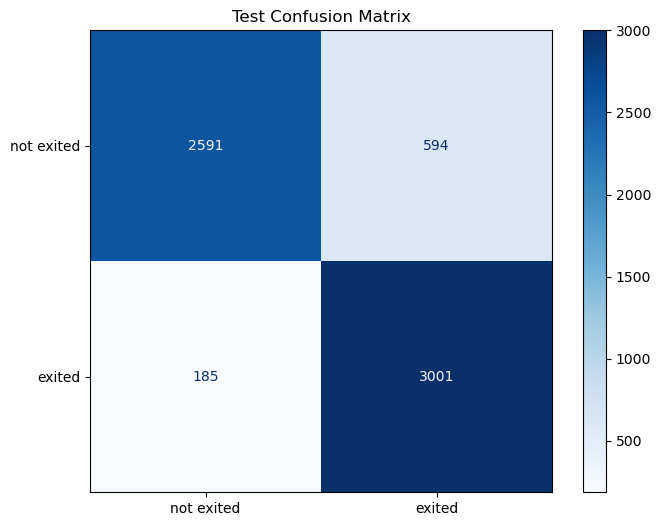

In [161]:
y_train_pred = gcv.predict(x_train)
y_test_pred = gcv.predict(x_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

train_score = gcv.score(x_train, y_train)
test_score = gcv.score(x_test, y_test)

print("Train score:", train_score)
print("Test score:", test_score)

plt.figure(figsize=(8, 6))
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=custom_labels)
disp_train.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.gca().set_xlabel("")
plt.gca().set_ylabel("")
plt.title("Train Confusion Matrix")
plt.show()

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=custom_labels)
disp_test.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.gca().set_xlabel("")
plt.gca().set_ylabel("")
plt.title("Test Confusion Matrix")
plt.show()

In [162]:

conf_matrix = confusion_matrix(y_test, y_test_pred)
results = classification_report(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nResults:\n", results)
print("\nAccuracy:", accuracy)

Confusion Matrix:
 [[2591  594]
 [ 185 3001]]

Results:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      3185
           1       0.83      0.94      0.89      3186

    accuracy                           0.88      6371
   macro avg       0.88      0.88      0.88      6371
weighted avg       0.88      0.88      0.88      6371


Accuracy: 0.8777272013812588


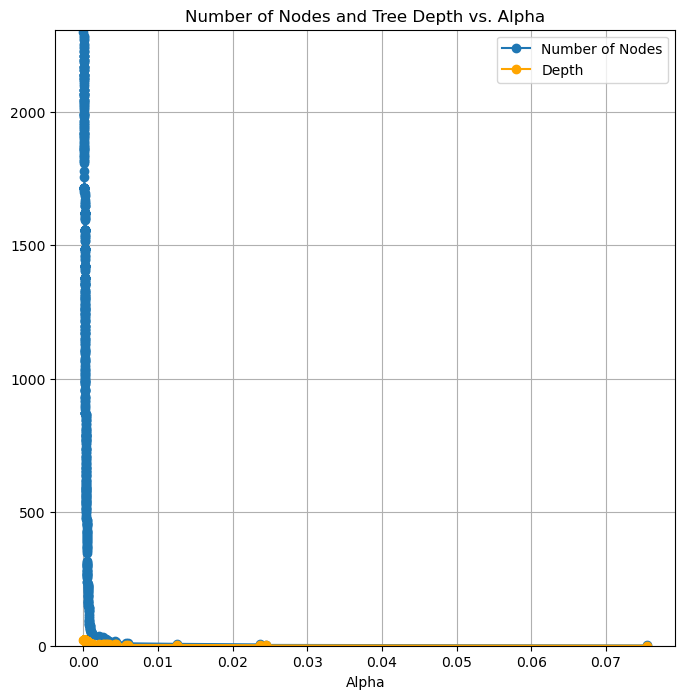

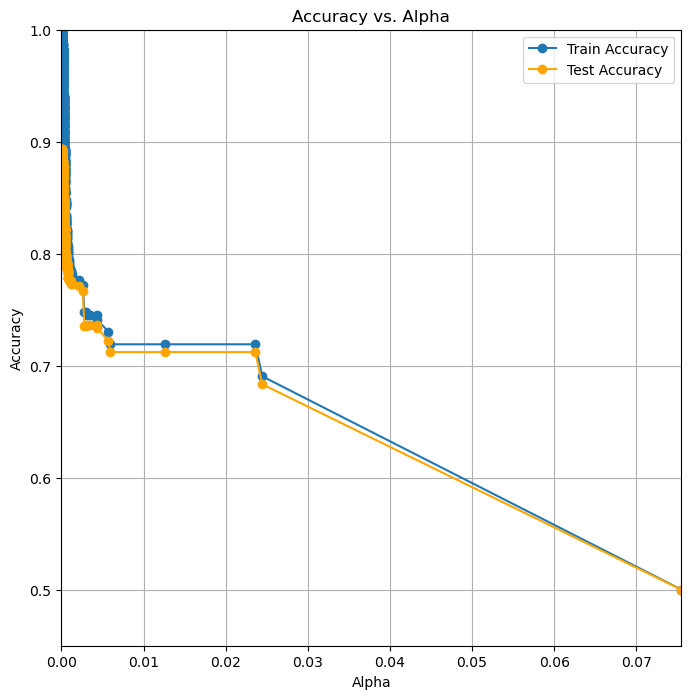

Best Alpha for Accuracy: 0.0
Best Test Accuracy: 0.8935802856694397


In [163]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# filter out negative or near-zero ccp_alpha values
ccp_alphas = ccp_alphas[ccp_alphas >= 0]

train_accuracies = []
test_accuracies = []
node_counts = []
tree_depths = []

# evaluate the model for each alpha
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=0)
    clf.fit(x_train, y_train)
    
    train_accuracies.append(clf.score(x_train, y_train))
    test_accuracies.append(clf.score(x_test, y_test))
    node_counts.append(clf.tree_.node_count)
    tree_depths.append(clf.tree_.max_depth)

plt.figure(figsize=(8, 8))
plt.plot(ccp_alphas, node_counts, marker='o', label="Number of Nodes")
plt.plot(ccp_alphas, tree_depths, marker='o', label="Depth", color="orange")
plt.xlabel("Alpha")
plt.ylim(0, max(node_counts) + 10)
plt.title("Number of Nodes and Tree Depth vs. Alpha")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(ccp_alphas, train_accuracies, marker='o', label="Train Accuracy")
plt.plot(ccp_alphas, test_accuracies, marker='o', label="Test Accuracy", color="orange")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.ylim(min(min(train_accuracies), min(test_accuracies)) - 0.05, 1.0)
plt.xlim(0, max(ccp_alphas))
plt.title("Accuracy vs. Alpha")
plt.legend()
plt.grid()
plt.show()

best_alpha_index = np.argmax(test_accuracies)
best_alpha = ccp_alphas[best_alpha_index]
best_accuracy = test_accuracies[best_alpha_index]

print("Best Alpha for Accuracy:", best_alpha)
print("Best Test Accuracy:", best_accuracy)

## Run 4: Train new model with alpha

In [164]:
dt2 = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
gcv1 = GridSearchCV(estimator=dt2, param_grid=params, cv=5)
gcv1.fit(x_train, y_train)    

/opt/anaconda3/envs/tf_env/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'class_weight': [None, 'balanced', {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 6, 8, 10]})

Train score: 0.9683935112506541
Test score: 0.8777272013812588


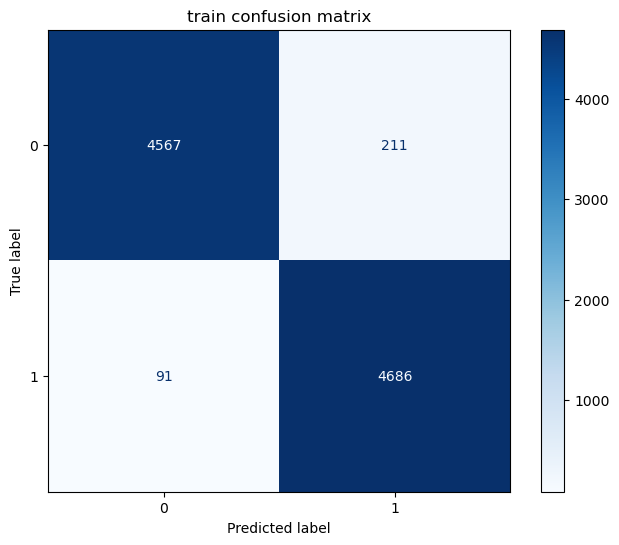

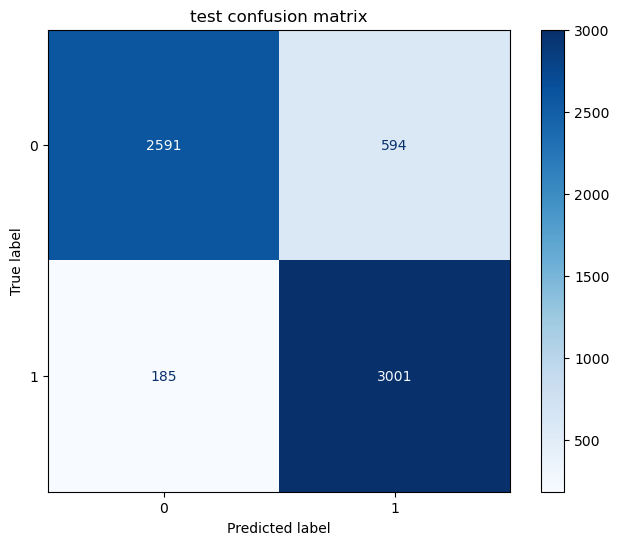

In [165]:
y_train_pred = gcv1.predict(x_train)
y_test_pred = gcv1.predict(x_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

train_score = gcv1.score(x_train, y_train)
test_score = gcv1.score(x_test, y_test)

print("Train score:", train_score)
print("Test score:", test_score)

plt.figure(figsize=(8, 6))
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=gcv1.classes_)
disp_train.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("train confusion matrix")
plt.show()

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=gcv1.classes_)
disp_test.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("test confusion matrix")
plt.show()

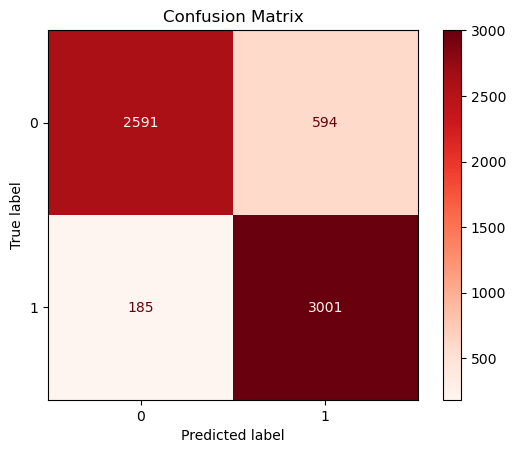

In [166]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=gcv1.classes_)
disp.plot(cmap='Reds', values_format='d')

plt.title("Confusion Matrix")
plt.show()

In [167]:

conf_matrix = confusion_matrix(y_test, y_test_pred)
results = classification_report(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nResults:\n", results)
print("\nAccuracy:", accuracy)

Confusion Matrix:
 [[2591  594]
 [ 185 3001]]

Results:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      3185
           1       0.83      0.94      0.89      3186

    accuracy                           0.88      6371
   macro avg       0.88      0.88      0.88      6371
weighted avg       0.88      0.88      0.88      6371


Accuracy: 0.8777272013812588


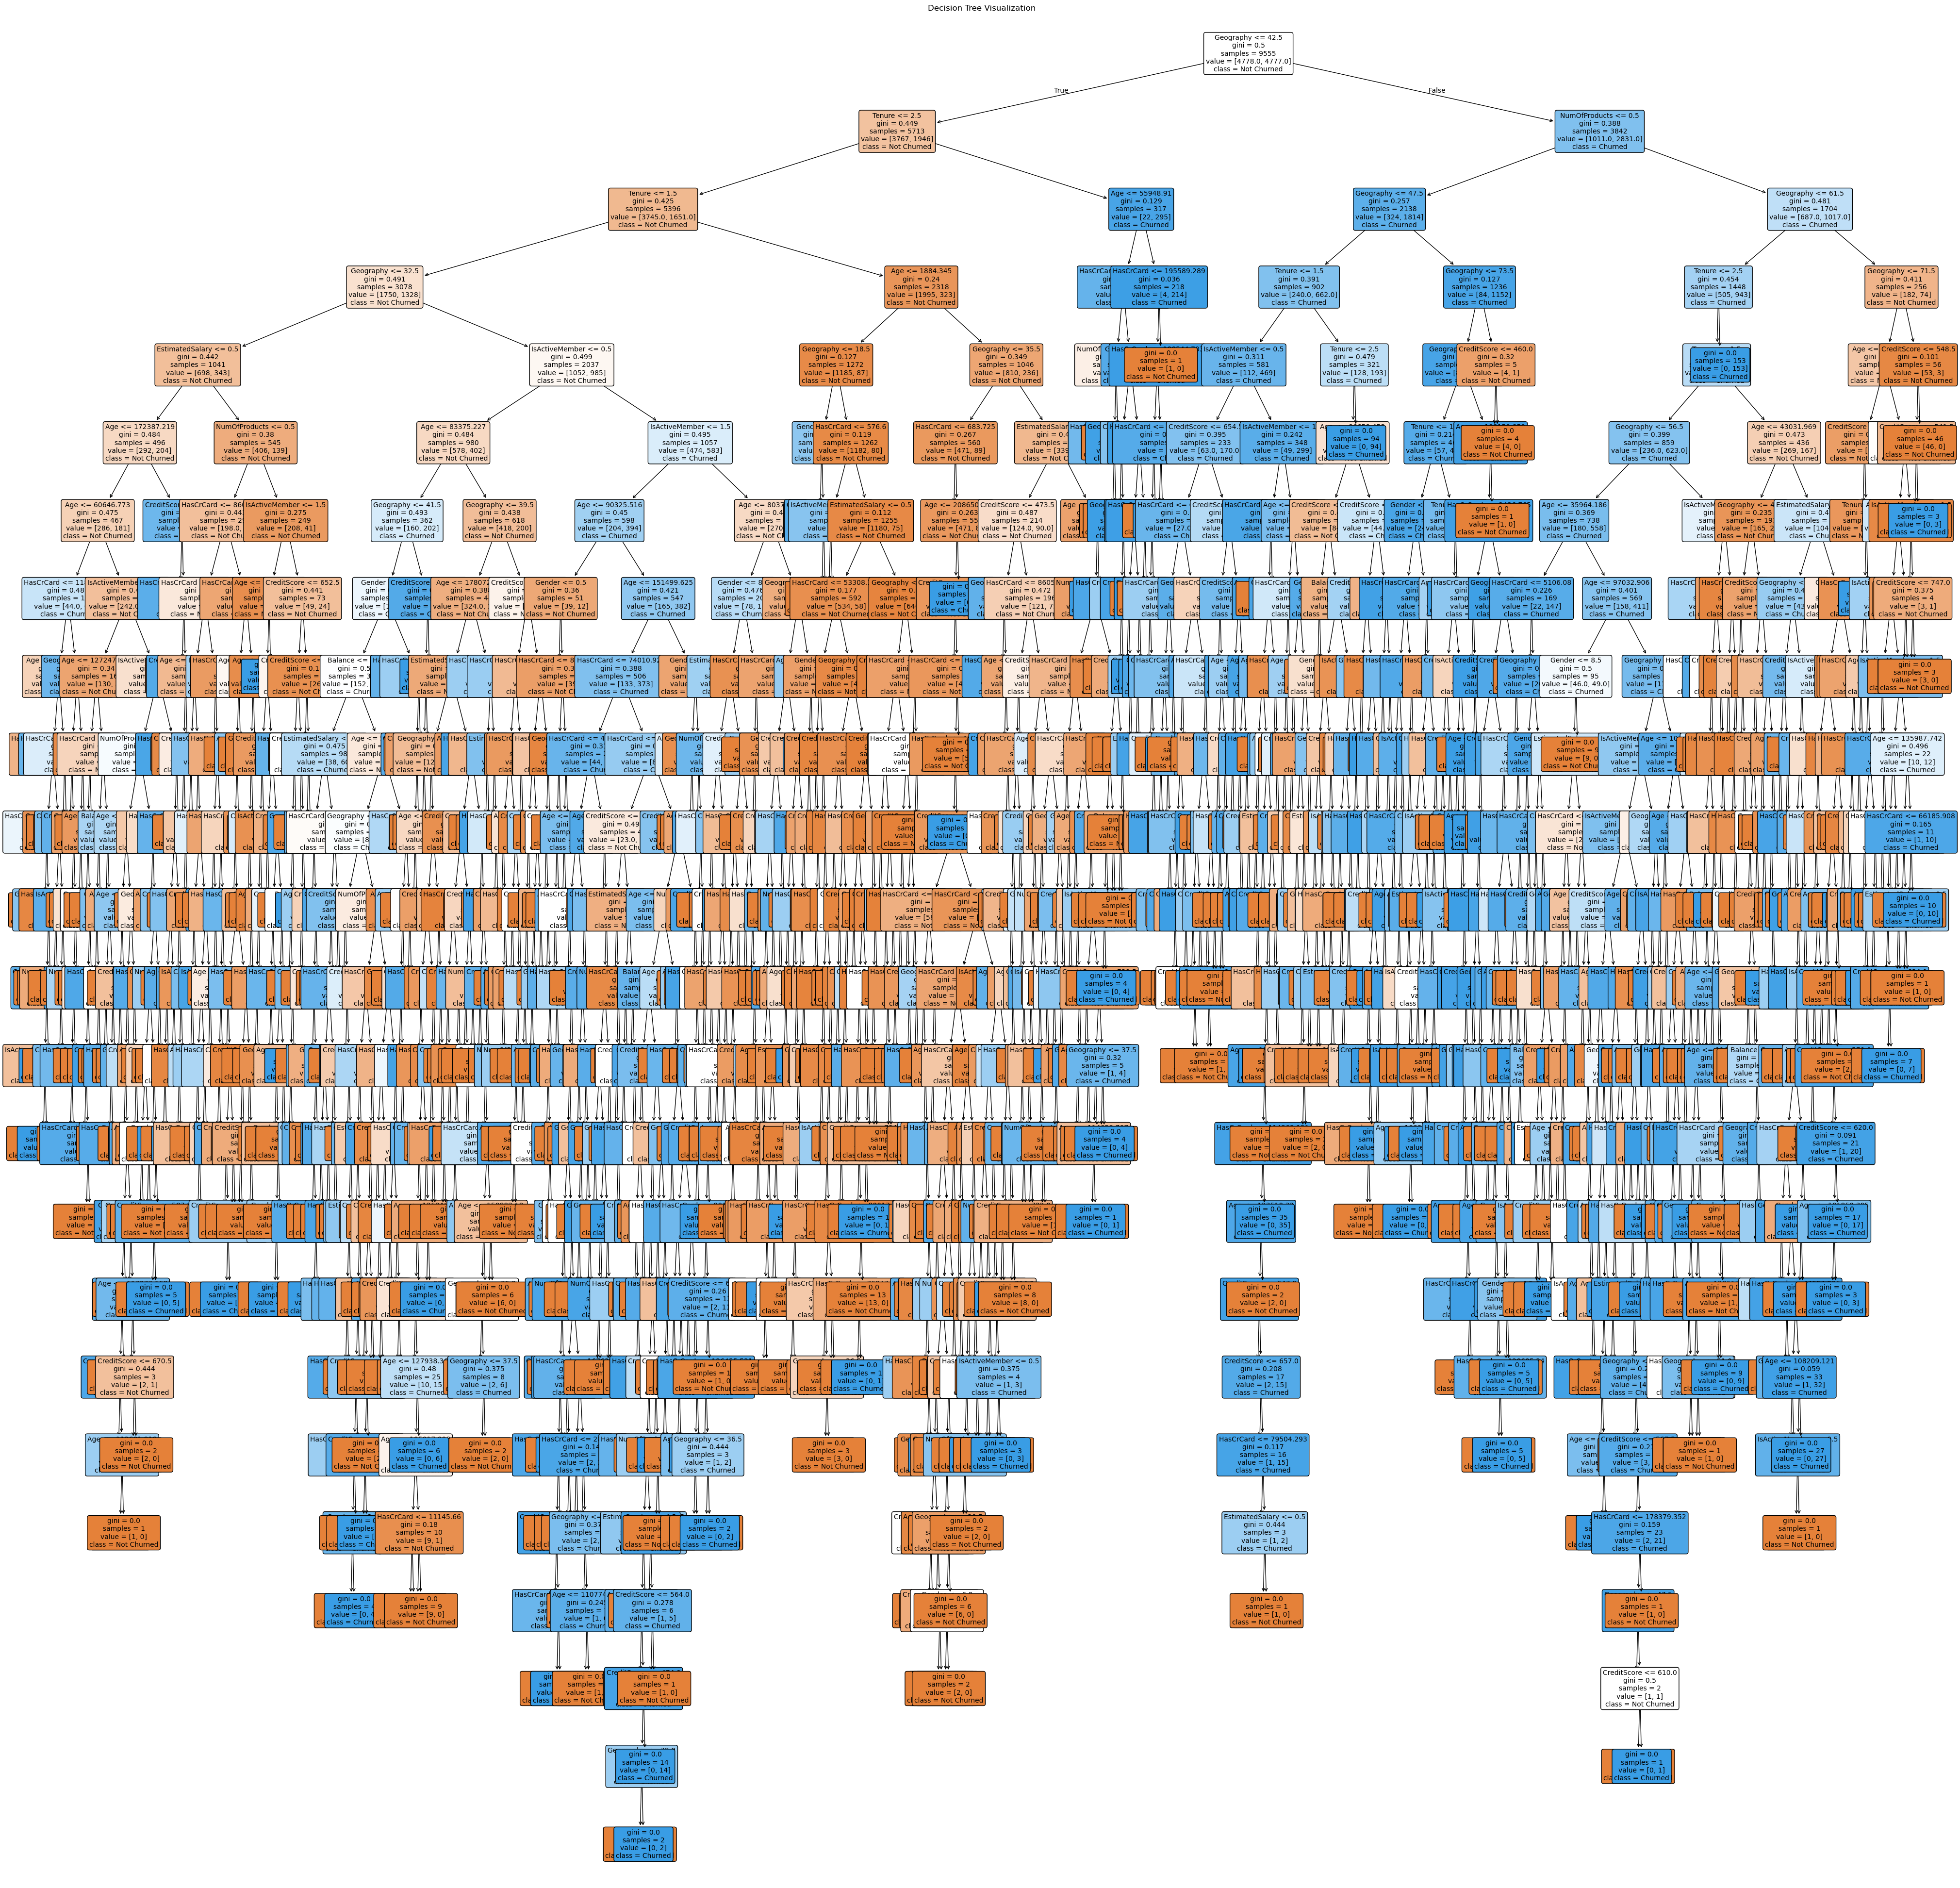

In [168]:
plt.figure(figsize=(50, 50))
plot_tree(
    dt,
    feature_names=feature_names,
    class_names=['Not Churned', 'Churned'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()